<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

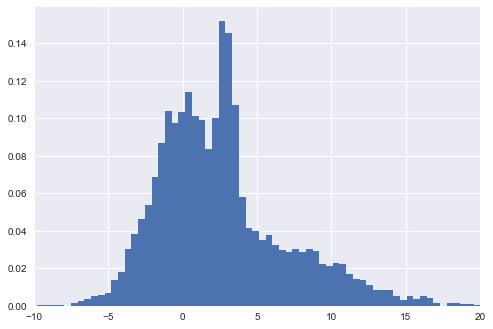

In [2]:
rng = np.random.default_rng(seed=2)
x = np.concatenate([rng.normal(0, 2, 2000),
                    rng.normal(5, 5, 2000),
                    rng.normal(3, 0.5, 600)])

fig, ax = plt.subplots()

ax.hist(x, 80, density=True)
ax.set_xlim(xmin=-10, xmax=20);

Gaussian mixture models will allow us to approximate this density:

In [3]:
from sklearn.mixture import GaussianMixture as GMM
X = x[:, np.newaxis]
clf = GMM(4, max_iter=500, random_state=3).fit(X)

In [4]:
xpdf = np.linspace(-10, 20, 1000)
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

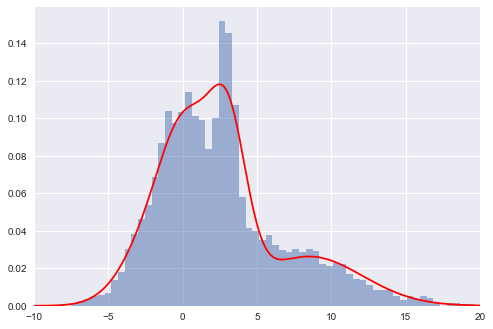

In [5]:
fig, ax = plt.subplots()

ax.hist(x, 80, density=True, alpha=0.5)
ax.plot(xpdf, density, '-r')
ax.set_xlim(xmin=-10, xmax=20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [6]:
clf.means_

array([[ 0.47015089],
       [ 8.48308554],
       [-1.49982944],
       [ 3.07759538]])

In [7]:
clf.covariances_

array([[[ 2.84905621]],

       [[13.06663368]],

       [[ 4.6972201 ]],

       [[ 1.58201113]]])

In [8]:
clf.weights_

array([0.28382214, 0.23838635, 0.22820235, 0.24958916])

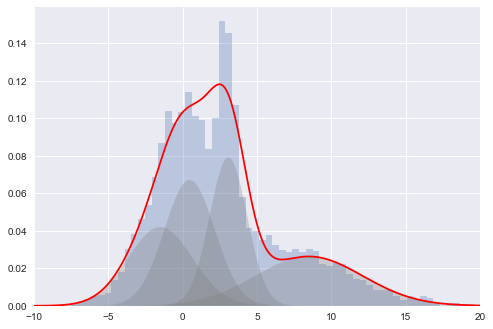

In [9]:
fig, ax = plt.subplots()

ax.hist(x, 80, density=True, alpha=0.3)
ax.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    ax.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
ax.set_xlim(xmin=-10, xmax=20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [10]:
print(clf.bic(X))
print(clf.aic(X))

25872.510821820342
25801.738894413094


Let's take a look at these as a function of the number of gaussians:

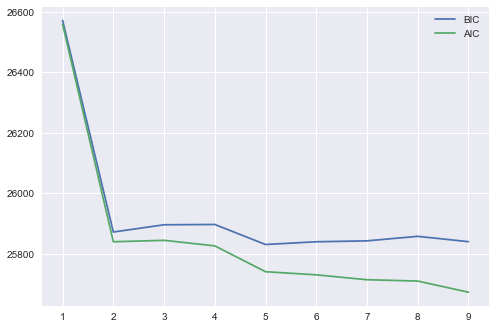

In [11]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, max_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

fig, ax = plt.subplots()

ax.plot(n_estimators, bics, label='BIC')
ax.plot(n_estimators, aics, label='AIC')
ax.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [12]:
rng = np.random.default_rng(seed=0)

# Add 20 outliers
true_outliers = np.sort(rng.integers(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

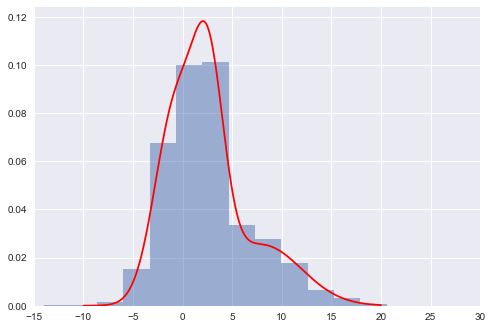

In [13]:
clf = GMM(4, max_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

fig, ax = plt.subplots()

ax.hist(y, 80, density=True, alpha=0.5)
ax.plot(xpdf, density_noise, '-r')
ax.set_xlim(xmin=-15, xmax=30);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

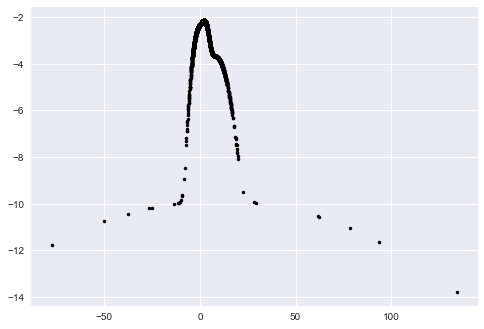

In [14]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y])
# log_likelihood = clf.score_samples(y[:, np.newaxis])[0]

fig, ax = plt.subplots()
ax.plot(y, log_likelihood, '.k');

In [15]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  76  188  346  806 1241 1416 2316 2351 2500 2575 2790 2908 2930 2987
 3355 3741 3912 4198 4301 4465]

detected outliers:
[ 188  346  806 1241 1416 2048 2193 2316 2351 2524 2575 2790 2908 2930
 2989 3355 3380 3381 3741 4198]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [16]:
set(true_outliers) - set(detected_outliers)

{76, 2500, 2987, 3912, 4301, 4465}

And here are the non-outliers which were spuriously labeled outliers:

In [17]:
set(detected_outliers) - set(true_outliers)

{2048, 2193, 2524, 2989, 3380, 3381}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

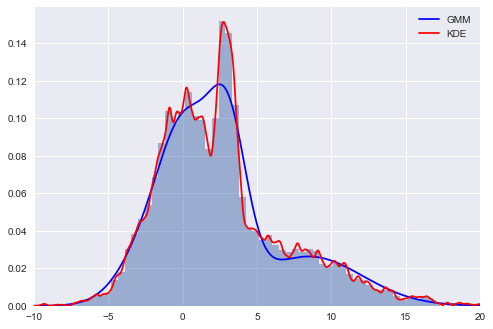

In [18]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

fig, ax = plt.subplots()

ax.hist(x, 80, density=True, alpha=0.5)
ax.plot(xpdf, density, '-b', label='GMM')
ax.plot(xpdf, density_kde, '-r', label='KDE')
ax.set_xlim(xmin=-10, xmax=20)
ax.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.